## Курсовой проект

#### Подключение библиотек и скриптов

In [110]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

#### Пути к директориям и файлам

In [111]:
TRAIN_DATASET_PATH = 'project_task/train.csv' # y_train, y_valid
TEST_DATASET_PATH = 'project_task/test.csv'

## Загрузка данных

Описание датасета

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [112]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [113]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [114]:
train_df.shape[1]-1 == test_df.shape[1]

True

In [115]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [116]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [117]:
# чтобы не забыть обработать эти категориальные признаки
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [118]:
train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

## Обзор данных

#### Целевая переменная (Price)

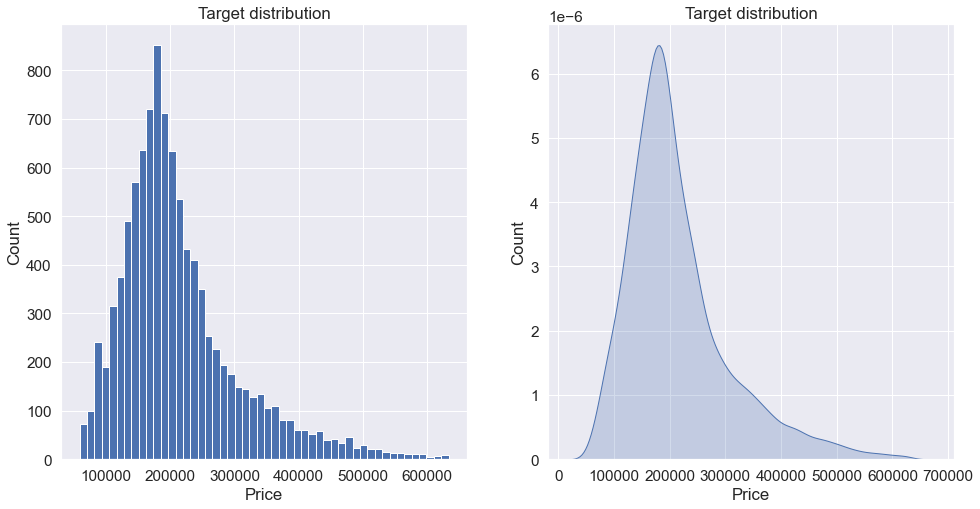

In [119]:
# логнормальное распределение
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(bins = 50)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')

plt.show()

#### - тут существенных выбросов нет

#### Далее посмотрим на остальные признаки

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>]],
      dtype=object)

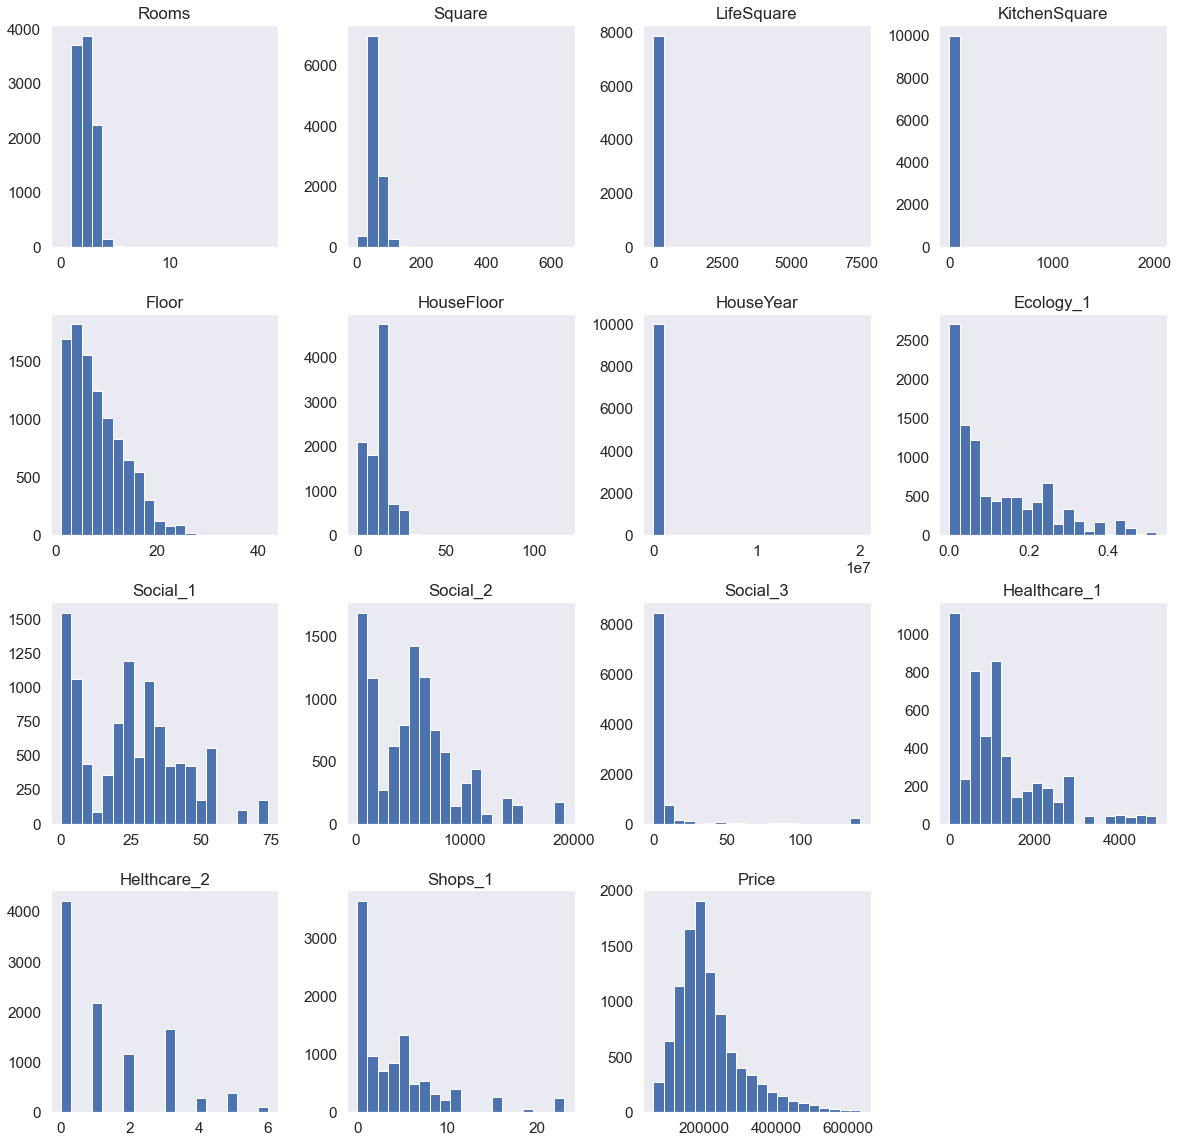

In [120]:
train_df.hist(figsize=(20, 20), bins=20, grid=False)

In [121]:
# Тут много непонятного. Rooms, Square, LifeSquare, KitchenSquare, HouseFloor, HouseYear, Social_3, Shops_1 - нуждаются в 
# обработке (пропуски и выбросы). 

#### Количественные переменные

In [122]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [123]:
# Замечаем что в наборе присутствуют нелогичные моменты (сымма площадей больше общей, этажность и тд.).
# Нулевые значения, где их быть не должно, нереальные цифры и тд.

### Категориальные переменные

In [124]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [125]:
# перекос в данных, возможно, они не будут очень полезными
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



### Выявим зависимости признаков (матрица корреляции)

<AxesSubplot:>

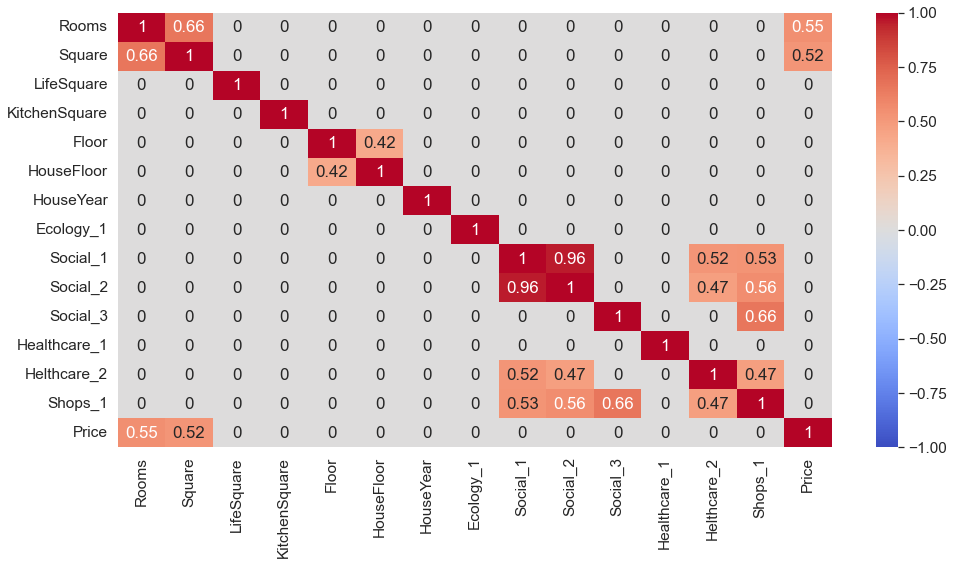

In [126]:
plt.figure(figsize = (16, 8))
sns.set(font_scale=1.4)
corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [127]:
# Social_1 и Social_2 - сильно коррелируют, в дальнейшем можно будет объединить их в один признак.


### Обработка выбросов

#### Rooms

In [128]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [ ]:
# все где 0 и больше 6 комнат - считаем неверным. Исходя из матрицы корреляции, замечаем что число комнат коррелирует с 
# площадью. Далее обучим промежуточную модель и подберем число комнат исходя из общей площади.

In [129]:
train_df.loc[train_df['Rooms'] > 6, 'Rooms'] = 0 

In [130]:
train_df['Rooms'].value_counts()

2.0    3880
1.0    3705
3.0    2235
4.0     150
5.0      18
0.0      11
6.0       1
Name: Rooms, dtype: int64

In [131]:
target = train_df.loc[train_df['Rooms'] != 0][['Rooms']]
y = pd.DataFrame(target, columns=["Rooms"])
X_train, X_test, y_train, y_test = train_test_split(train_df.loc[train_df['Rooms'] != 0][['Square']], 
                                                    y, test_size = 0.3, random_state = 42)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [132]:
y_pred = lr.predict(X_test)
check_test = pd.DataFrame({
    "y_test": y_test["Rooms"],    
    "y_pred": y_pred.flatten()
})

check_test['y_pred'] = round(check_test['y_pred'])
check_test.head(10)

,y_test,y_pred
5843,1.0,1.0
3061,3.0,3.0
8755,2.0,1.0
2666,2.0,2.0
35,2.0,2.0
6082,2.0,2.0
388,3.0,3.0
1569,2.0,2.0
8417,3.0,3.0
9507,2.0,2.0


In [133]:
from sklearn.metrics import mean_squared_error
mean_squared_error(check_test["y_pred"], check_test["y_test"])

0.4004004004004004

In [134]:
zero_rooms = train_df.loc[train_df['Rooms'] == 0][['Square']]
y_predict_zeroes = lr.predict(zero_rooms)
y_predict_zeroes

array([[1.95477232],
       [1.44485146],
       [2.00021197],
       [1.52233604],
       [1.71500081],
       [1.52772492],
       [2.67371669],
       [5.80864348],
       [2.51665272],
       [3.94264402],
       [0.53520567]])

In [135]:
train_df.loc[train_df['Rooms'] == 0][['Square']]

,Square
2004,59.056975
2194,38.697117
2728,60.871266
3780,41.790881
5894,49.483501
6088,42.006046
6401,87.762616
7644,212.932361
7929,81.491446
9767,138.427694


In [136]:
check_test = pd.DataFrame({
    "y_test": zero_rooms['Square'],    
    "y_pred": y_predict_zeroes.flatten()
})

check_test['y_pred'] = round(check_test['y_pred'])
check_test.head(10)

,y_test,y_pred
2004,59.056975,2.0
2194,38.697117,1.0
2728,60.871266,2.0
3780,41.790881,2.0
5894,49.483501,2.0
6088,42.006046,2.0
6401,87.762616,3.0
7644,212.932361,6.0
7929,81.491446,3.0
9767,138.427694,4.0


In [137]:
rooms_square_cat = train_df.groupby('Rooms').mean()['Square']
rooms_square_cat

Rooms
0.0     74.081559
1.0     41.323277
2.0     56.788214
3.0     76.903234
4.0     98.377544
5.0    122.614941
6.0     59.414334
Name: Square, dtype: float64

In [138]:
train_df.loc[train_df['Rooms'] == 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


In [140]:
square_min_value = np.quantile(train_df['Square'], q=0.01)
train_df.loc[train_df['Square'] < square_min_value] 


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
111,13875,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.114376
130,8800,23,1.0,29.706031,NaN,0.0,5,12.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,60502.583500
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323
234,4935,23,1.0,28.859885,NaN,1.0,12,11.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,68375.615508
242,1098,101,1.0,23.015919,15.739110,3.0,3,5.0,1967,0.225825,A,B,41,6558,7,1548.0,3,2,B,132427.987621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,10476,90,1.0,21.121279,15.202620,3.0,4,5.0,1964,0.265089,B,B,37,5288,0,1937.0,3,2,B,113846.123763
9739,5354,85,1.0,28.535084,12.733642,6.0,4,9.0,1967,0.037178,B,B,52,11217,1,2300.0,1,7,B,142269.268090
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
9990,10635,21,1.0,18.983962,11.419796,2.0,1,5.0,1967,0.194489,B,B,47,8004,3,125.0,3,5,B,112411.221700


In [142]:
square_max_value = np.quantile(train_df['Square'], q=0.99)
train_df.loc[train_df['Square'] > square_max_value]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
136,5284,27,4.0,119.914990,78.518874,13.0,8,12.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,221374.057293
286,2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.837047
349,6006,62,3.0,121.844004,122.497641,1.0,3,3.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,193847.642016
403,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B,622888.825328
443,3627,27,3.0,120.771217,118.048978,1.0,8,1.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,275644.708378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9641,14143,13,5.0,119.008007,69.033727,11.0,13,17.0,2001,0.090799,B,B,74,19083,2,NaN,5,15,B,434774.356335
9663,9098,30,3.0,135.020523,NaN,1.0,2,4.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,167269.566699
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
9846,1205,23,2.0,148.671938,100.201652,1.0,1,3.0,2013,0.014073,B,B,2,475,0,NaN,0,0,B,152464.848743


In [13]:
zero_rooms = train_df.loc[train_df['Rooms'] == 0][['Square']]
rooms_square_df = train_df.loc[train_df['Rooms'] != 0][['Square']]
rooms_square_df

,Square
0,115.027311
1,39.832524
2,78.342215
3,40.409907
4,64.285067
...,...
9995,49.090728
9996,64.307684
9997,29.648057
9998,32.330292


In [14]:
rooms_square_cat = train_df.groupby('Rooms').mean()['Square']
rooms_square_cat

Rooms
0.0      81.620358
1.0      41.323277
2.0      56.788214
3.0      76.903234
4.0      98.377544
5.0     122.614941
6.0      59.414334
10.0     59.964120
19.0     42.006046
Name: Square, dtype: float64

In [15]:
zero_rooms

,Square
2194,38.697117
3780,41.790881
5894,49.483501
6401,87.762616
7644,212.932361
7929,81.491446
9767,138.427694
9869,2.377248


In [16]:
target = train_df.loc[train_df['Rooms'] != 0][['Rooms']]
target

,Rooms
0,3.0
1,1.0
2,3.0
3,1.0
4,2.0
...,...
9995,2.0
9996,2.0
9997,1.0
9998,1.0


In [17]:
y = pd.DataFrame(target, columns=["Rooms"])
X_train, X_test, y_train, y_test = train_test_split(rooms_square_df, y, test_size = 0.4)

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [19]:
y_pred = lr.predict(X_test)
check_test = pd.DataFrame({
    "y_test": y_test["Rooms"],    
    "y_pred": y_pred.flatten()
})

check_test.head(10)

,y_test,y_pred
3474,2.0,2.153566
9062,2.0,2.181468
9162,3.0,2.103974
9342,2.0,1.810905
8336,2.0,1.701232
2242,1.0,1.641141
6218,2.0,1.678702
9492,1.0,1.445771
1297,1.0,1.661561
8688,1.0,1.446726


In [20]:
from sklearn.metrics import mean_squared_error
mean_squared_error(check_test["y_pred"], check_test["y_test"])

0.38942572884202636

In [21]:
y_pred1 = lr.predict(zero_rooms)
y_pred1


array([[1.38928747],
       [1.47723587],
       [1.69591886],
       [2.78410354],
       [6.3423833 ],
       [2.60582903],
       [4.22439186],
       [0.3567995 ]])

In [22]:
zero_rooms

,Square
2194,38.697117
3780,41.790881
5894,49.483501
6401,87.762616
7644,212.932361
7929,81.491446
9767,138.427694
9869,2.377248


In [23]:
y

,Rooms
0,3.0
1,1.0
2,3.0
3,1.0
4,2.0
...,...
9995,2.0
9996,2.0
9997,1.0
9998,1.0


In [24]:
y_pred = lr.predict(X_test)
check_test = pd.DataFrame({
    "Square": zero_rooms['Square'],
    "y_pred": y_pred1.flatten()
})
check_test['y_pred'] = round(check_test['y_pred'])
check_test.head(10)

,Square,y_pred
2194,38.697117,1.0
3780,41.790881,1.0
5894,49.483501,2.0
6401,87.762616,3.0
7644,212.932361,6.0
7929,81.491446,3.0
9767,138.427694,4.0
9869,2.377248,0.0


In [25]:
zero_rooms

,Square
2194,38.697117
3780,41.790881
5894,49.483501
6401,87.762616
7644,212.932361
7929,81.491446
9767,138.427694
9869,2.377248


<AxesSubplot:>

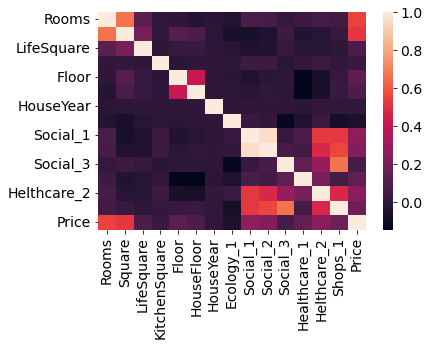

In [26]:
sns.heatmap(train_df.corr())

<AxesSubplot:>

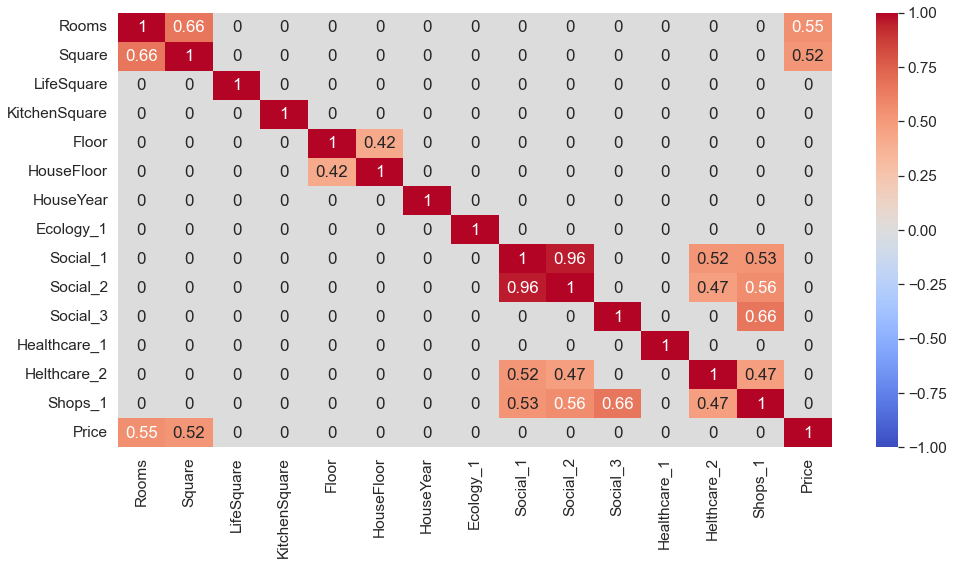

In [43]:
plt.figure(figsize = (16, 8))
sns.set(font_scale=1.4)
corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [16]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64